<a href="https://colab.research.google.com/github/2walkingfish/Neuromatch_Project_133/blob/master/Explore_steinmetz_extra_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

References for data set:

1) [Youtube video](https://www.youtube.com/watch?v=WXn4-FpVaOo) describing experiment, data and analysis;

2) [Distributed correlates of visually-guided behavior across the mouse brain.](https://www.biorxiv.org/content/10.1101/474437v1.abstract) 
Nicholas A. Steinmetz,  Peter Zatka-Haas, ProfileMatteo Carandini, Kenneth D. Harris 

3) [Selection of data containing wavelets](https://github.com/NeuromatchAcademy/course-content/blob/master/projects/load_steinmetz_extra.ipynb)

Initial question for this project was whether the topology of the circuits is getting more complicated within sequential trials of task performing. We studied this question based on Steinmetz et al. data set. However, before building the circuit, we need to define what determines connectivity between single neutrons. 
To start with features analysis, we explored temporal components of spike waveforms for the probe with the highest amplitude by reducing dimensionality with PCA and TSNE methods, calculated optimal amount of clusters and plot waveforms concerning clusters. We find that waveforms in each cluster have distinguished parameters of amplitude and spike width. 
It yet does not provide the answer to the question, so we thought what can be done next: 1) Plot clusters statistics per different brain areas to define whether any of waveforms defined by a region; 2) Calculate shifts of waveforms in milliseconds to build a signal spreading map; 3) Compare results per different stages of trial; 4) Compare results per first and last trails. 
The main result of exploration is asking more in-depth questions about data set and neural circuits formation.  

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

In [140]:
#@title Elbow method to calculate optimal amount of clusters
def elbow_method(data_to_cluster,plot_titile):

  percent_of_var_explained = []

  cluster_range = range(1,10)
  for cluster_nums in cluster_range:
    print(cluster_nums)
    kmeans_m = KMeans(n_clusters = cluster_nums,  random_state=0).fit(data_to_cluster)
    percent_of_var_explained.append(sum(np.min(cdist(data_to_cluster, kmeans_m.cluster_centers_,'euclidean')
    ,axis = 1))/data_to_cluster.shape[0])

  plt.plot(cluster_range, percent_of_var_explained)
  plt.gca().set_aspect('equal')
  plt.xlabel('number of clusters')
  plt.ylabel('percent of variance explained')
  plt.title(f'The Elbow Method showing the optimal k for {plot_titile}')
  plt.show()


 

In [161]:
#@title Function to calculate clusters, plot clusters and show average amplitude of wavelets per each cluster
def k_means_cluster_and_amplitude_plot(n_clusters, data_to_cluster, initial_data_stack):
  kmeans = KMeans(n_clusters = n_clusters,  random_state=1).fit(data_to_cluster)
  labels_kmeans = kmeans.labels_

  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  for i in np.unique(labels_kmeans):
    plt.scatter(data_to_cluster[labels_kmeans == i, 0],data_to_cluster[labels_kmeans == i,1], label = str(i))
  plt.legend()
  plt.gca().set_aspect('equal', adjustable='box')
  plt.xlabel('PCA_1')
  plt.ylabel('PCA_2')
  plt.title('PCA data split to 4 clusters using KMeans algorithm')

  plt.subplot(1,2,2)
  for i in np.unique(labels_kmeans):
    plt.plot(np.mean(initial_data_stack[labels_kmeans==i], axis=0), label = str(i))
  plt.xlabel('amplitude')
  plt.ylabel('time bins')
  plt.title('Amplitude per cluster')
  plt.legend()
  return labels_kmeans



In [165]:
#@title Plot all waveforms with cluster average
def plot_waveforms_splited_by_clusters(initial_data_stack, labels):
  fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize= (15,7),squeeze=True)

  plt.setp(ax, yticks=[-2,0,2,4])
  # ax.set_title("Waveforms in clusters")
  # ax.set_ylabel('waweform amplitude')
  # ax.set_xlabel('time 30kHz per second')
  iterations = 0
  for i in range(2):
      for j in range(2):
          ax[i,j].plot(initial_data_stack[labels==iterations].T, color = 'cyan', alpha = 0.1)
          ax[i,j].plot(np.mean(initial_data_stack[labels==iterations], axis=0), color = 'k')
          iterations+=1
          ax[i,j].set_title(f'Cluster = {iterations}')

  # set labels
  plt.setp(ax[-1, :], xlabel='time 30kHz per second')
  plt.setp(ax[:, 0], ylabel='amplitude')
  plt.suptitle('Waveforms splited by clusters')





In [9]:
#@title Data retrieval
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [10]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [11]:
#@title Data loading
dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']


# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = dat_LFP[11]
print(dat.keys())
dat = dat_WAV[11]
print(dat.keys())
dat = dat_ST[11]
print(dat.keys())

dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp'])
dict_keys(['waveform_w', 'waveform_u', 'trough_to_peak'])
dict_keys(['ss', 'ss_passive'])


`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files. 

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [12]:
#@title Data dimentionality 
print("dat_LFP[1]['lfp']", dat_LFP[1]['lfp'].shape)
print("dat_LFP[1]['lfp_passive']", dat_LFP[1]['lfp_passive'].shape)
print("dat_LFP[1]['brain_area_lfp']",dat_LFP[1]['brain_area_lfp'])

print("dat_ST[0]['ss'].shape", dat_ST[0]['ss'].shape)
print("dat_ST[0]['ss'].shape", dat_ST[0]['ss_passive'].shape)

dat_LFP[1]['lfp'] (4, 251, 250)
dat_LFP[1]['lfp_passive'] (4, 150, 250)
dat_LFP[1]['brain_area_lfp'] ['CA1', 'VISl', 'POST', 'VISpm']
dat_ST[0]['ss'].shape (734, 214)
dat_ST[0]['ss'].shape (734, 150)


In [13]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

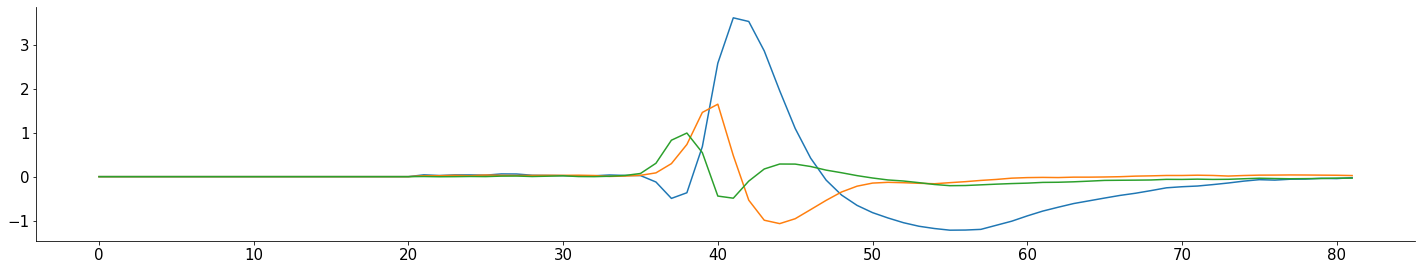

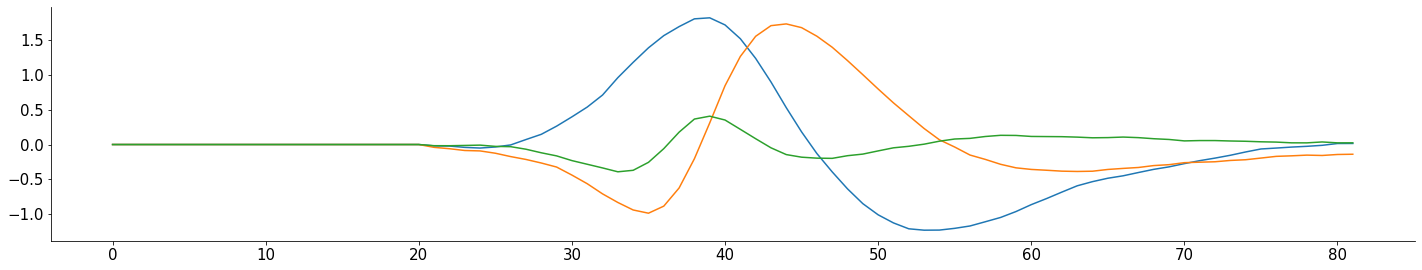

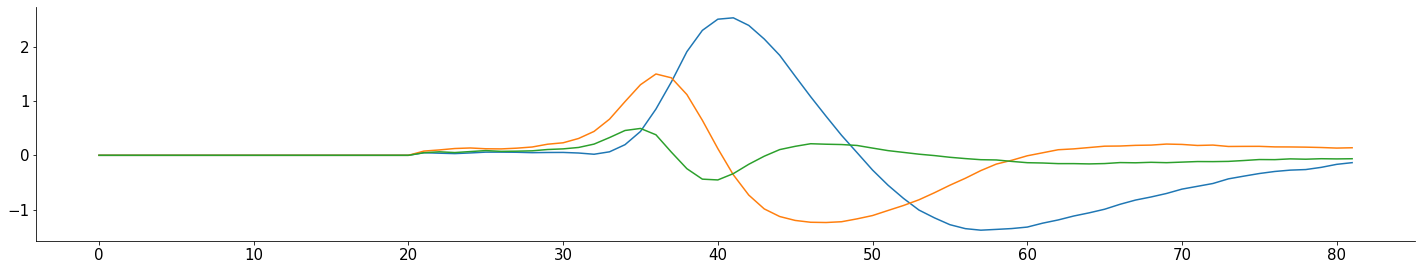

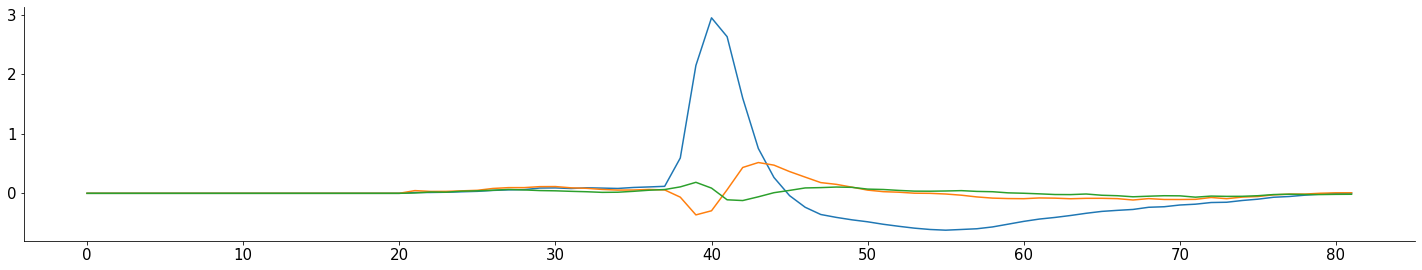

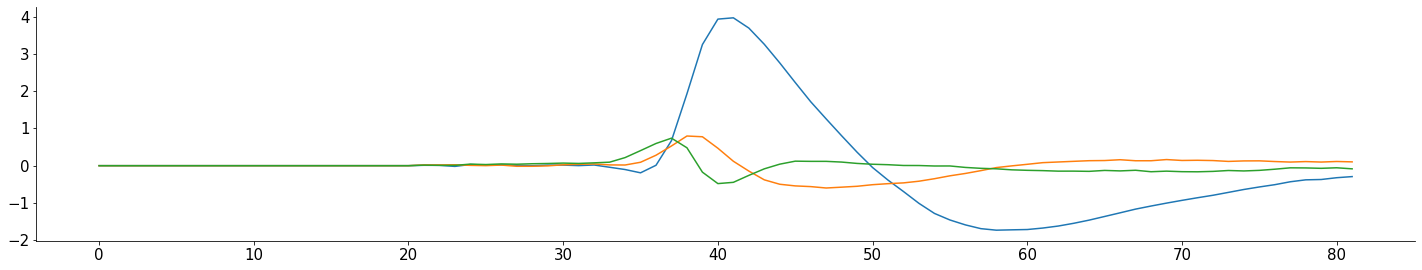

In [14]:
# all waveforms per experiment dat_WAV[38]['waveform_w'].shape[0]
for i in range(0, 5):
  plt.plot(dat_WAV[38]['waveform_w'][i])
  plt.show()

In [18]:
print("dat_WAV[38]['waveform_w'].shape[0]", dat_WAV[38]['waveform_w'].shape[0])

dat_WAV[38]['waveform_w'].shape[0] 1348


For each trial, we have a set of tree potentials measured by different parts of one electrode. To continue the investigation, we will select one with the highest amplitude and apply dimensionality reduction methods to check whether data can be separated into distinct clusters. Separatable clusters would be a sign of functional connectivity of neurons. 

As seen from the waveform plot before 20-time counts neurons are resting, thus we can cut this part of the signal to improve PCA accuracy.

explained_variance_ratio_ [0.4980742  0.22734275]
singular_values [117.20923  79.18726]
explained_variance_ratio_ [0.4980742  0.22734275]


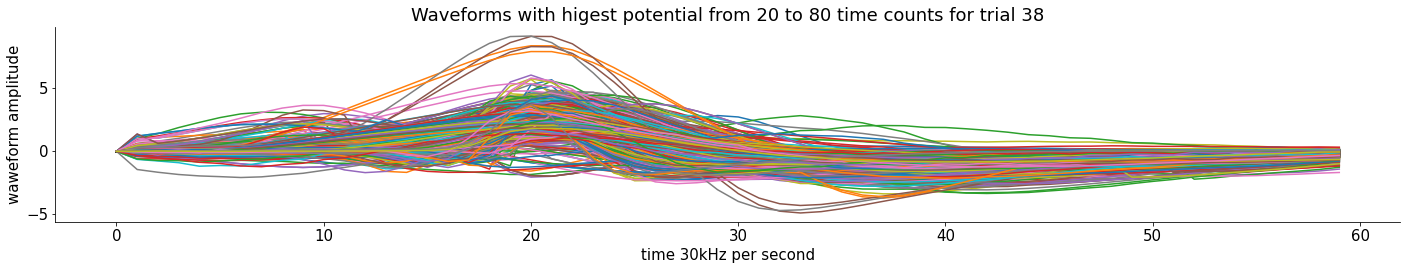

In [28]:
selected_trial = 38 
pca = PCA(n_components = 2)

i_range = range(0, dat_WAV[selected_trial]['waveform_w'].shape[0])

data_stack = np.empty_like(dat_WAV[selected_trial]['waveform_w'][0,20:80,0])
for i in i_range:
  if (dat_WAV[selected_trial]['waveform_w'][i,20:80,0].any()!= np.nan):
    data_stack =np.vstack((data_stack, dat_WAV[selected_trial]['waveform_w'][i,20:80,0]))

plt.plot(data_stack.T)

plt.ylabel('waweform amplitude')
plt.xlabel('time 30kHz per second')
plt.title("Waveforms with higest potential from 20 to 80 time counts for trial 38")

plt.show()

In [133]:
result_pca = pca.fit(data_stack)

print('explained_variance_ratio_', pca.explained_variance_ratio_)
print('singular_values', pca.singular_values_)
print('explained_variance_ratio_', pca.explained_variance_ratio_)

explained_variance_ratio_ [0.49807444 0.22734275]
singular_values [117.20925  79.18726]
explained_variance_ratio_ [0.49807444 0.22734275]


Text(0, 0.5, 'PCA_2')

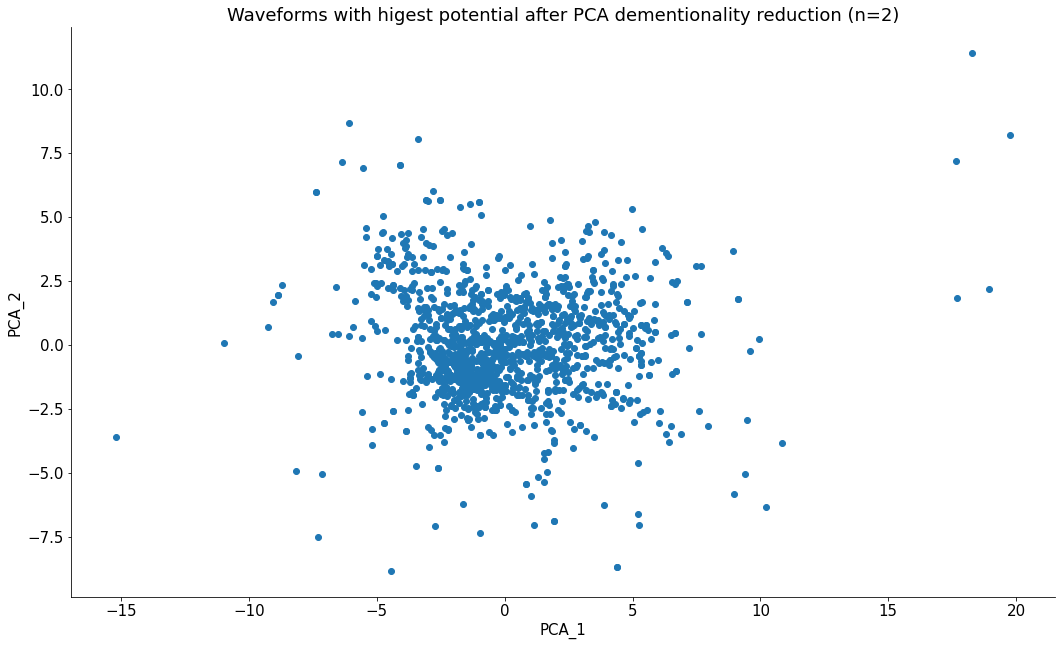

In [111]:
transformation_results = pca.fit_transform(data_stack)

plt.figure(figsize=(15,15))
plt.scatter(transformation_results[:,0],transformation_results[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Waveforms with higest potential after PCA dementionality reduction (n=2)")

plt.xlabel('PCA_1')
plt.ylabel('PCA_2')

(2, 60)


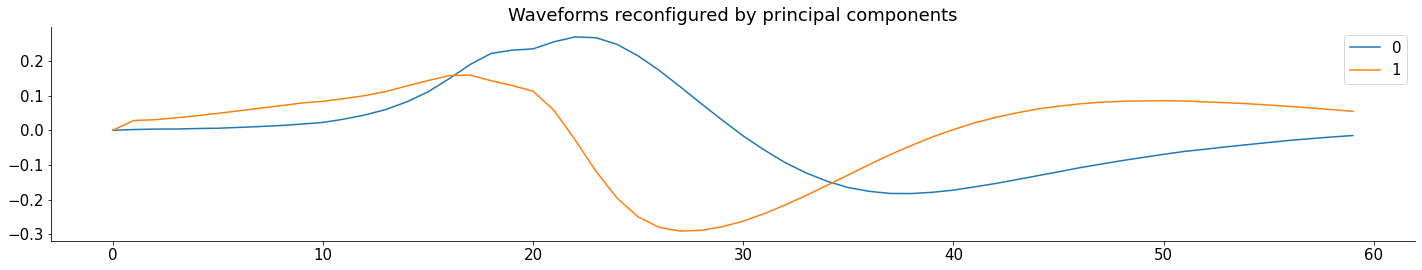

In [112]:
prinsipal_components = pca.fit(data_stack)
prinsipal_components.get_params

print(prinsipal_components.components_.shape)
for i in range(0,2):
  plt.plot(prinsipal_components.components_[i], label = str(i))
plt.legend()

plt.title("Waveforms reconfigured by principal components")
plt.show()

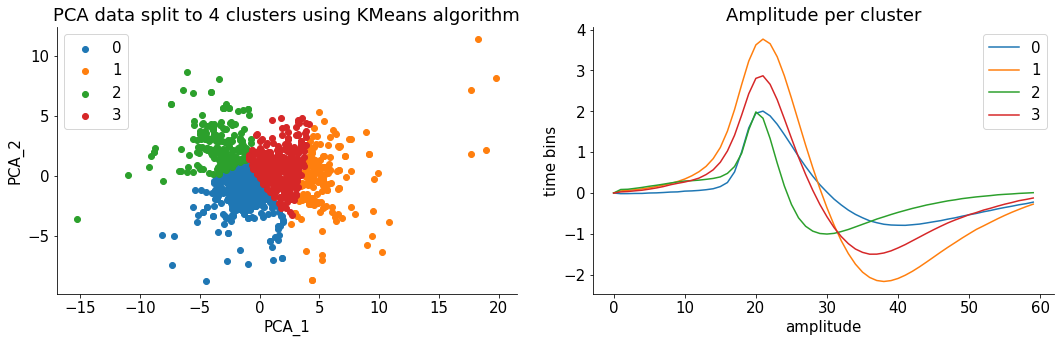

In [171]:
labels_kmeans_pca = k_means_cluster_and_amplitude_plot(4, transformation_results, data_stack)

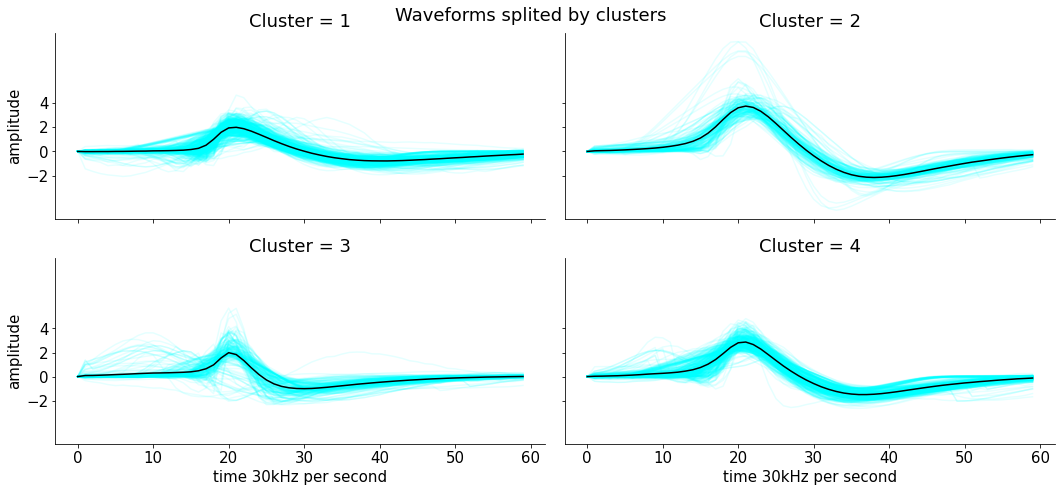

In [172]:
plot_waveforms_splited_by_clusters(data_stack, labels_kmeans_pca)

**Apply TSNE for wawelet component with the highest amplitude**


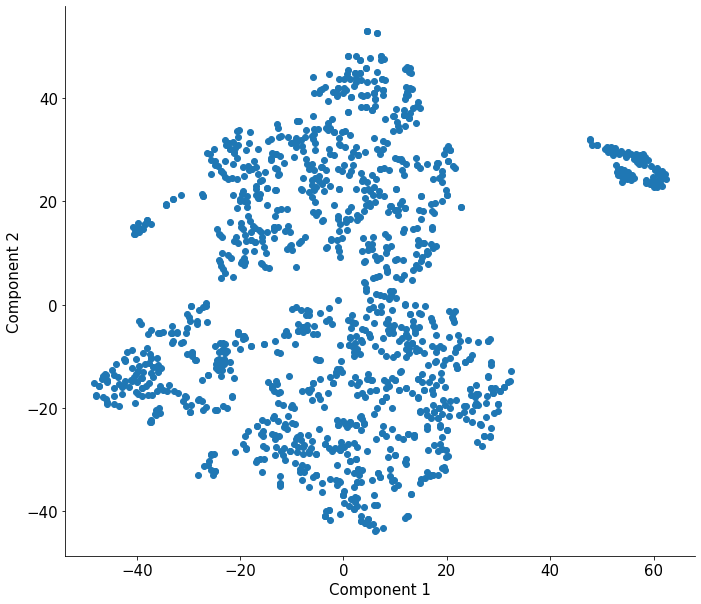

In [138]:
tsne_model = TSNE(n_components=2, perplexity=30, random_state=1) 
fit_tsne = tsne_model.fit(data_stack)
tsne_results = tsne_model.fit_transform(data_stack)
  
plt.figure(figsize=(10,10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.gca().set_aspect('equal', adjustable='box')


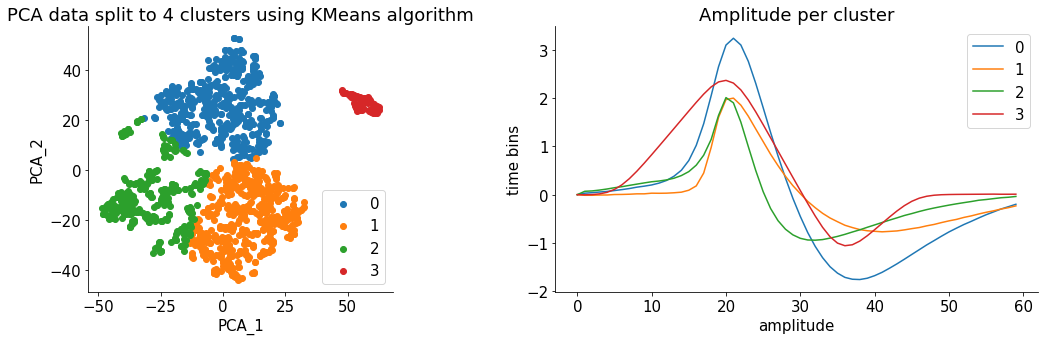

In [169]:
labels_kmeans_tsne = k_means_cluster_and_amplitude_plot(4, tsne_results, data_stack)

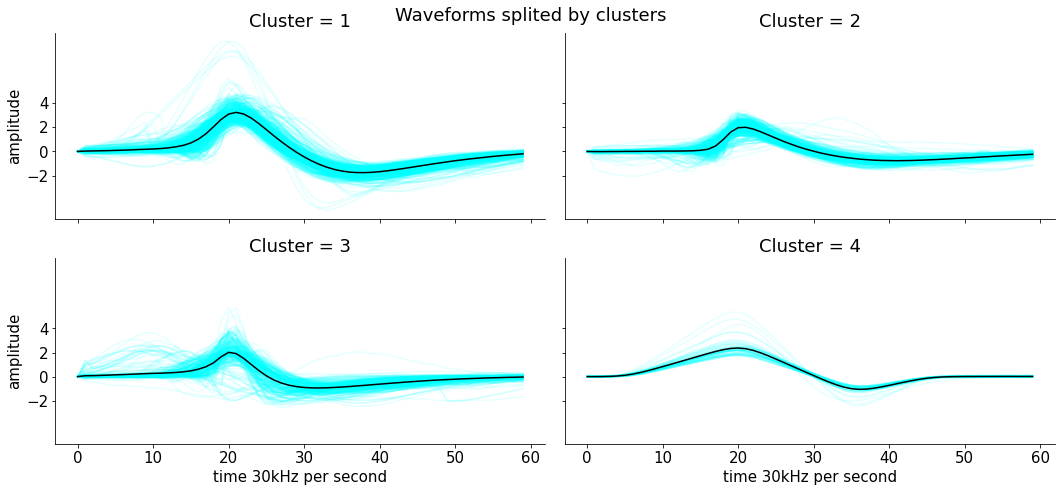

In [170]:
plot_waveforms_splited_by_clusters(data_stack,labels_kmeans_tsne)